<a href="https://colab.research.google.com/github/arifsoul/DIS-2/blob/Arif/DIS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental.preprocessing import RandomContrast, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.backend import clear_session
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.transform import resize
import imgaug.augmenters as iaa
import cv2

batch_size = 32
size_img = (100, 100, 3)

#Prepare dataset


In [3]:
path_dataset = '/content/drive/MyDrive/Citra BISINDO'
# folders = sorted(os.listdir(path_dataset))
folders = ['O', 'S']
print(folders)

['O', 'S']


In [4]:
dataset_collection = []
target = []
classes = []

cls_count = 0
print('ID\tSample\t\tName')
for folder in folders:
    dir = os.path.join(path_dataset, folder)
    filename = os.listdir(dir)
    count_img = 0

    if len(filename) > 0:
        for f in filename:
            img_path =  os.path.join(dir, f)  
            dataset_collection.append(img_path)
            target.append(cls_count)
            count_img += 1 

        print('{}\t{} sample\t{}'.format(cls_count, count_img, folder))
        classes.append(folder)
        cls_count += 1

print('\nTotal:\t{} sample'.format(len(dataset_collection)))

ID	Sample		Name
0	12 sample	O
1	12 sample	S

Total:	24 sample


In [5]:
dataset_collection

['/content/drive/MyDrive/Citra BISINDO/O/body white (1).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/body dot (2).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/body white (2).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/wall white (3).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/body dot (4).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/wall white (2).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/body white (3).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/wall white (1).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/body dot (1).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/body white (4).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/body dot (3).jpg',
 '/content/drive/MyDrive/Citra BISINDO/O/wall white (4).jpg',
 '/content/drive/MyDrive/Citra BISINDO/S/body dot (3).jpg',
 '/content/drive/MyDrive/Citra BISINDO/S/wall white (1).jpg',
 '/content/drive/MyDrive/Citra BISINDO/S/wall white (3).jpg',
 '/content/drive/MyDrive/Citra BISINDO/S/body dot (4).jpg',
 '/content/drive/MyD

In [10]:
all_data = []
labels = []
count = 0

for img_path, label in zip(dataset_collection, target):
    print(count)
    orig_img = cv2.imread(img_path)
    seq_aug = [
        None,
        iaa.Affine(rotate=10),
        iaa.Affine(rotate=-10),
        iaa.Affine(rotate=20),
        iaa.Affine(rotate=-20),
        iaa.Affine(rotate=30),
        iaa.Affine(rotate=-30),
        iaa.Affine(rotate=30),
        iaa.Affine(rotate=-30),
        iaa.Fliplr(0.5),
        iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.LinearContrast((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )

    ]

    for aug in seq_aug:
        img = orig_img.copy()
        if aug != None:
            img = aug(image=img)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img = resize(img, size_img)
        all_data.append(img)
        labels.append(label)
    count += 1

print('All Training:', len(all_data))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
All Training: 408


In [ ]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa


ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order

images_aug = seq(images=images)

#Split Train, Val, Test

In [2]:
numpy_dir = "/content/drive/MyDrive/numpy_dis_2/"
if not os.path.exists(numpy_dir):
  os.mkdir(numpy_dir)

In [32]:
np.save(numpy_dir+"all_data.npy", all_data)
np.save(numpy_dir+"labels.npy", labels)

In [3]:
all_data = np.load(numpy_dir+"all_data.npy")
labels = np.load(numpy_dir+"labels.npy")

In [5]:
# classes_folder = sorted(os.listdir('/content/drive/MyDrive/Citra BISINDO'))
classes_folder = ['O', 'S']
print(classes_folder)

['O', 'S']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
X_test, X_val, y_test, y_val = np.array(X_test), np.array(X_val), np.array(y_test), np.array(y_val)

print('ID\tData Train\tData Val\tData Test\tName')
for i in range(len(classes_folder)):
    count_train, count_val, count_test = len(np.where(y_train==i)[0]), len(np.where(y_val==i)[0]), len(np.where(y_test==i)[0])
    print('{}\t{} sample\t{} sample\t{} sample\t{}'.format(i, count_train, count_val, count_test, classes_folder[i]))
print('\nTotal:\t {} sample\t {} sample\t {} sample'.format(len(y_train), len(y_val), len(y_test)))

ID	Data Train	Data Val	Data Test	Name
0	163 sample	21 sample	20 sample	O
1	163 sample	20 sample	21 sample	S

Total:	 326 sample	 41 sample	 41 sample


In [7]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

## Machine Learning


In [10]:
# Data Augmentation

data_augmentation = Sequential()
data_augmentation.add(RandomFlip("horizontal", input_shape=size_img))
data_augmentation.add(RandomZoom(0.1))
data_augmentation.add(RandomContrast(0.2))


In [11]:
# Create Model
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=size_img))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

clear_session()
model.summary()

In [ ]:
# Compiling
optimizer = Adam(learning_rate=0.0001)

#early stopping to monitor the validation accuracy and avoid overfitting
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience= 3, factor= 0.5, min_lr= 1e-6, verbose=1)

#autosave best model
checkpoint = ModelCheckpoint("/content/drive/MyDrive/GCA - Safepediasircon15/Datasets/Classifier/Train-numpy/own_model_100x100eval2.hdf5",monitor='val_accuracy',verbose=1,mode='max', save_best_only=True,save_weights_only=False ,save_freq="epoch")


In [ ]:
# Compiling
model.compile(optimizer='adam',loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [ ]:
# Train Model
epochs=100
batch_size=32
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=batch_size, callbacks = [early_stop, rlrop,checkpoint],verbose = 1)

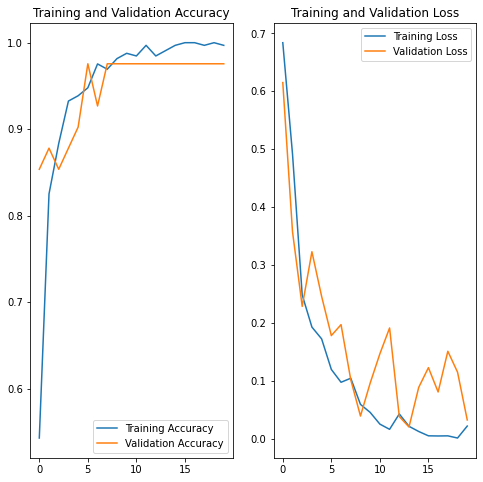

In [14]:
# Visualization
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
# Evaluation
p_pred = model.predict(X_test)
y_pred = np.where(p_pred > 0.5, 1, 0)

cr = classification_report(y_test_cat, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.95      0.98        21

   micro avg       0.98      0.98      0.98        41
   macro avg       0.98      0.98      0.98        41
weighted avg       0.98      0.98      0.98        41
 samples avg       0.98      0.98      0.98        41



In [23]:
score = model.evaluate(X_test, y_test_cat, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.0645904690027237
Test accuracy: 0.9756097793579102


In [ ]:
X_test.shape


(312, 100, 100, 3)

In [28]:
directory = '/content/drive/MyDrive/Citra BISINDO/O'
filename = os.listdir(directory)

for f in filename:
    img_path = os.path.join(directory, f)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = resize(img, size_img)
    img = img.flatten()

    pred_idx = model.predict([img])[0]
    pred_proba = model.predict_proba([img])[0]

    yhat = np.argmax(pred_proba, axis=0)
    print(f, classes[yhat], pred_proba[yhat], classes[pred_idx])

ValueError: ignored

In [ ]:
# Test image in folder 'test'
!find . -name ".DS_Store" -delete

from keras.preprocessing import image
import numpy as np
import os

directory = 'test/'
image_name = []
images = []
collect_img = []
count_img = 9
classes_folder = sorted(os.listdir('/content/drive/MyDrive/Citra BISINDO'))

# for img in list_file[:count_img]:
#     image_name.append(img)
#     img = os.path.join(directory, img)
#     img = image.load_img(img, target_size=size_img)
#     img_np = image.img_to_array(img)
#     img = np.expand_dims(img_np, axis=0)
#     images.append(img)
#     collect_img.append(img_np)

# images = np.vstack(images)

classes_pred = model.predict(X_test)

plt.figure(figsize=(20, 20))
for i in range(len(X_test[0][:count_img][:count_img])):
    idX_class = int(classes[i][0])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].astype("uint8"))
    plt.title(classes_folder[i])
    plt.axis("off")

In [ ]:
# Test image in folder 'test'
!find . -name ".DS_Store" -delete

from keras.preprocessing import image
import numpy as np
import os
directory = 'test/'
image_name = []
images = []
collect_img = []
count_img = 9
list_file = sorted(os.listdir(directory))

for img in list_file[:count_img]:
    image_name.append(img)
    img = os.path.join(directory, img)
    img = image.load_img(img, target_size=size_img)
    img_np = image.img_to_array(img)
    img = np.expand_dims(img_np, axis=0)
    images.append(img)
    collect_img.append(img_np)

images = np.vstack(images)
classes = model.predict(images)

plt.figure(figsize=(20, 20))
for i in range(len(list_file[:count_img][:count_img])):
    idX_class = int(classes[i][0])
    ax = plt.subplot(3, 3, i + 1)

    if idX_class == 1:
      # print(i+1, image_name[i],'    ', name_class[1])
      plt.imshow(collect_img[i].astype("uint8"))
      plt.title(image_name[i]+' '+name_class[1])
      plt.axis("off")
      
    else:
      # print(i+1, image_name[i],'    ', name_class[0])
      plt.imshow(collect_img[i].astype("uint8"))
      plt.title(image_name[i]+' =>'+name_class[0])
      plt.axis("off")

# Camera Acces

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
import html
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io

In [ ]:
def jsob_to_image(js_object):
  # decode base64 image
  image_bytes = b64decode(js_object.split(',')[1])
  # convert bytes to numpy array
  img_array = np.frombuffer(image_bytes, dtype=np.uint8)
  # convert numpy array into OpenCV BGR 
  frame = cv2.imdecode(img_array, flags=1)

  return frame

In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="blue: red; font-weight: bold;">' +
          'click here to stop the video</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; 
      captureCanvas.height = 480; 
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame() {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
  
            
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame():
  data = eval_js('stream_frame()')
  return data

# Get the webcam stream and forward it to python 
video_stream()

while True:
    frame_js = video_frame()
    if not frame_js:
        break
    img = jsob_to_image(frame_js["img"])

In [ ]:
# Get the webcam stream and forward it to python 
video_stream()

while True:
    frame_js = video_frame()
    if not frame_js:
        break
    img = jsob_to_image(frame_js["img"])